In [3]:
import pandas as pd
from datetime import datetime, timedelta
from geopy import distance
import numpy as np
import matplotlib.pyplot as plt
import folium
import warnings
warnings.filterwarnings("ignore")

In [39]:
df = pd.read_csv('data/r55_all.csv')
df.head(71)

,Unnamed: 0,Unnamed: 0.1,des,dly,hdg,lat,lon,pdist,pid,rt,tablockid,tatripid,tmstmp,vid,day,minute,hour,tmstmp_rounded
0,167,167,Ashland,False,1,41.793224,-87.583817,1430,1291,55,55 -608,1063865,2020-01-08 09:12:51,1538,8,12,9,2020-01-08 09:12:00
1,168,168,Museum of Science & Industry,False,87,41.793186,-87.720797,10170,5424,55,55 -613,1083560,2020-01-08 09:17:31,1471,8,17,9,2020-01-08 09:17:00
2,169,169,Museum of Science & Industry,False,89,41.793824,-87.684472,20261,5424,55,55 -601,1083559,2020-01-08 09:17:42,8067,8,17,9,2020-01-08 09:17:00
3,170,170,Museum of Science & Industry,False,88,41.794120,-87.631119,35083,5424,55,55 -612,1083558,2020-01-08 09:17:33,1446,8,17,9,2020-01-08 09:17:00
4,171,171,Museum of Science & Industry,False,92,41.795008,-87.598020,44648,5424,55,55 -609,1083557,2020-01-08 09:17:22,1466,8,17,9,2020-01-08 09:17:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66,1824,1824,Midway Orange Line,False,271,41.795580,-87.590042,3913,5425,55,55 -616,1083572,2020-01-08 10:46:28,1407,8,46,10,2020-01-08 10:46:00
67,1825,1825,Midway Orange Line,False,268,41.794636,-87.630685,15590,5425,55,55 -615,1083571,2020-01-08 10:46:28,1520,8,46,10,2020-01-08 10:46:00
68,1826,1826,Midway Orange Line,False,271,41.793978,-87.662794,24501,5425,55,55 -614,1083570,2020-01-08 10:46:20,1421,8,46,10,2020-01-08 10:46:00
69,1827,1827,Midway Orange Line,False,267,41.793308,-87.703571,35751,5425,55,55 -613,1083569,2020-01-08 10:46:32,1471,8,46,10,2020-01-08 10:46:00


In [5]:
# lets fix these odd times in the automated 2 min interval API calls
def fix_time(time):
    time = str(time)
    dt = datetime.strptime(time, '%Y-%m-%d %H:%M:%S') 
    delta = timedelta(minutes=1) if dt.minute % 2 == 1 else timedelta(minutes=0)
    return dt - delta

df['tmstmp_rounded'] = df['tmstmp_rounded'].apply(fix_time)
df['tmstmp_rounded']

0       2020-01-08 09:12:00
1       2020-01-08 09:16:00
2       2020-01-08 09:16:00
3       2020-01-08 09:16:00
4       2020-01-08 09:16:00
                ...        
69441   2020-01-22 11:22:00
69442   2020-01-22 11:24:00
69443   2020-01-22 11:24:00
69444   2020-01-22 11:24:00
69445   2020-01-22 11:24:00
Name: tmstmp_rounded, Length: 69446, dtype: datetime64[ns]

In [40]:
# load bus stops table
bus_stops = pd.read_csv('data/CTA_BusStops.csv').drop('OWLROUTES', 1).dropna()

# filter out all routes except 55
_55_stops = bus_stops[bus_stops['ROUTESSTPG'].str.contains('(^|.*,)55(,.*|$)', regex = True)]
_55_stops.head(5)

,SYSTEMSTOP,OBJECTID,the_geom,STREET,CROSS_ST,DIR,POS,ROUTESSTPG,CITY,STATUS,PUBLIC_NAM,POINT_X,POINT_Y
94,10532,287,POINT (-87.654463797 41.79375704),GARFIELD,RACINE,EB,FS,55,CHICAGO,1,Garfield & Racine,-87.654464,41.793757
142,10607,17,POINT (-87.67457833700001 41.79396924399998),GARFIELD,DAMEN,WB,FS,55,CHICAGO,1,Garfield & Damen,-87.674578,41.793969
152,10629,27,POINT (-87.727949148 41.79324073700002),55TH STREET,KEELER,WB,NS,55,CHICAGO,1,55th Street & Keeler,-87.727949,41.793241
464,10495,338,POINT (-87.73991155599998 41.79294408599998),55TH STREET,KILPATRICK,EB,FS,55,CHICAGO,1,55th Street & Kilpatrick,-87.739912,41.792944
495,10549,369,POINT (-87.61615239499997 41.79441234500001),GARFIELD,KING DRIVE,EB,NS,55,CHICAGO,1,Garfield & King Drive,-87.616152,41.794412


In [7]:
# assert that systemstop numbers are unique
assert len(set(_55_stops['SYSTEMSTOP'])) == len(_55_stops)

# expose stops that do not fall under Eastbound and Westbound convention
_55_stops[~_55_stops['DIR'].isin(['EB', 'WB'])]

,SYSTEMSTOP,OBJECTID,the_geom,STREET,CROSS_ST,DIR,POS,ROUTESSTPG,CITY,STATUS,PUBLIC_NAM,POINT_X,POINT_Y
2982,1655,3047,POINT (-87.58394846700003 41.79350191399999),S HYDE PARK,56TH STREET,SB,NS,"6,28,55",CHICAGO,1,S Hyde Park & 56th Street,-87.583948,41.793502
5219,1517,5094,POINT (-87.58380227800001 41.793315870000015),S HYDE PARK,56TH STREET,NB,NS,"6,28,55",CHICAGO,1,S Hyde Park & 56th Street,-87.583802,41.793316
5245,14122,5120,POINT (-87.73900345700002 41.78622885599998),MIDWAY TERMINAL,ORANGE LINE STATION,SWB,TERM,55,CHICAGO,1,Midway Orange Line Station,-87.739003,41.786229
8802,10551,9595,POINT (-87.60735134800001 41.794863256999975),PAYNE DRIVE,55TH STREET,NEB,NS,55,CHICAGO,1,Payne Drive & 55th Street,-87.607351,41.794863
10888,1654,8099,POINT (-87.58402031000003 41.79498672099999),S HYDE PARK,55TH STREET,SB,FS,"6,28,55",CHICAGO,1,S Hyde Park & 55th Street,-87.584020,41.794987


In [8]:
# SB S Hyde Park and 56th St
_55_stops.loc[2982, 'DIR'] ='EB' 

# NB S Hyde Park and 56th St
_55_stops.loc[5219, 'DIR'] ='WB'

# WB Midway
_55_stops.loc[5245, 'DIR'] ='WB'

# NEB Payne Dr
_55_stops.loc[8802, 'DIR'] ='EB'

# SB S Hyde Park and 55th St
_55_stops.loc[10888, 'DIR'] ='EB'

# no outliers left
_55_stops[~_55_stops['DIR'].isin(['EB', 'WB'])]

,SYSTEMSTOP,OBJECTID,the_geom,STREET,CROSS_ST,DIR,POS,ROUTESSTPG,CITY,STATUS,PUBLIC_NAM,POINT_X,POINT_Y


In [9]:
# get eastbound 55 stops in order
east_stops = _55_stops[_55_stops['DIR'] == 'EB'].sort_values('POINT_X')
east_stops['STOP_NUM'] = np.arange(len(east_stops))
east_stops

,SYSTEMSTOP,OBJECTID,the_geom,STREET,CROSS_ST,DIR,POS,ROUTESSTPG,CITY,STATUS,PUBLIC_NAM,POINT_X,POINT_Y,STOP_NUM
464,10495,338,POINT (-87.73991155599998 41.79294408599998),55TH STREET,KILPATRICK,EB,FS,55,CHICAGO,1,55th Street & Kilpatrick,-87.739912,41.792944,0
8913,10496,7627,POINT (-87.73751922000002 41.79299879000001),55TH STREET,4600 WEST RR CROSSING,EB,FS,55,CHICAGO,1,4600 W 55th Street,-87.737519,41.792999,1
10856,10497,11010,POINT (-87.73512757200001 41.79304438700001),55TH STREET,KILBOURN,EB,FS,55,CHICAGO,1,55th Street & Kilbourn,-87.735128,41.793044,2
4192,10498,4569,POINT (-87.73266121500001 41.79304769999999),55TH STREET,KOSTNER,EB,FS,55,CHICAGO,1,55th Street & Kostner,-87.732661,41.793048,3
8855,10499,10519,POINT (-87.73061529900002 41.793064171000026),55TH STREET,KILDARE,EB,NS,55,CHICAGO,1,55th Street & Kildare,-87.730615,41.793064,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10550,10562,10022,POINT (-87.59044102899998 41.794740280999974),55TH STREET,BLACKSTONE,EB,NS,55,CHICAGO,1,55th Street & Blackstone,-87.590441,41.794740,64
3903,10563,3967,POINT (-87.58774890799998 41.795113130999994),55TH STREET,LAKE PARK,EB,NS,"55,171",CHICAGO,1,55th Street & Lake Park,-87.587749,41.795113,65
10888,1654,8099,POINT (-87.58402031000003 41.79498672099999),S HYDE PARK,55TH STREET,EB,FS,"6,28,55",CHICAGO,1,S Hyde Park & 55th Street,-87.584020,41.794987,66
2982,1655,3047,POINT (-87.58394846700003 41.79350191399999),S HYDE PARK,56TH STREET,EB,NS,"6,28,55",CHICAGO,1,S Hyde Park & 56th Street,-87.583948,41.793502,67


In [10]:
# get westbound 55 stops, need to swap kilpatrick and midway orange line
west_stops = _55_stops[_55_stops['DIR'] == 'WB'].sort_values('POINT_X')
old_idxs = list(west_stops.index.values)
new_idxs = [old_idxs[1], old_idxs[0]] + old_idxs[2:]
west_stops = west_stops.reindex(new_idxs)[::-1]
west_stops['STOP_NUM'] = np.arange(len(west_stops))
west_stops

,SYSTEMSTOP,OBJECTID,the_geom,STREET,CROSS_ST,DIR,POS,ROUTESSTPG,CITY,STATUS,PUBLIC_NAM,POINT_X,POINT_Y,STOP_NUM
5219,1517,5094,POINT (-87.58380227800001 41.793315870000015),S HYDE PARK,56TH STREET,WB,NS,"6,28,55",CHICAGO,1,S Hyde Park & 56th Street,-87.583802,41.793316,0
10490,10566,9018,POINT (-87.584154098 41.795284391999985),55TH STREET,HYDE PARK BLVD,WB,FS,"55,171",CHICAGO,1,55th Street & Hyde Park Blvd,-87.584154,41.795284,1
4690,10567,4816,POINT (-87.58805466000001 41.79528829399999),55TH STREET,LAKE PARK,WB,FS,"55,171",CHICAGO,1,55th Street & Lake Park,-87.588055,41.795288,2
2307,10568,2683,POINT (-87.59017599999999 41.79559175600002),55TH STREET,BLACKSTONE,WB,NS,55,CHICAGO,1,55th Street & Blackstone,-87.590176,41.795592,3
4689,10569,4815,POINT (-87.59160088800002 41.79556507799998),55TH STREET,DORCHESTER,WB,NS,"55,171",CHICAGO,1,55th Street & Dorchester,-87.591601,41.795565,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6205,15366,6080,POINT (-87.73275981500001 41.793188129999976),55TH STREET,KOSTNER,WB,NS,55,CHICAGO,1,55th Street & Kostner,-87.732760,41.793188,61
2228,10632,2604,POINT (-87.73521928299999 41.793158613),55TH STREET,KILBOURN,WB,NS,55,CHICAGO,1,55th Street & Kilbourn,-87.735219,41.793159,62
897,10633,1024,POINT (-87.73783810200001 41.79315410700002),55TH STREET,4600 WEST RR CROSSING,WB,NS,55,CHICAGO,1,4600 W 55th Street,-87.737838,41.793154,63
712,17030,586,POINT (-87.739988068 41.79316492200002),55TH STREET,KILPATRICK,WB,NS,55,CHICAGO,1,55th Street & Kilpatrick,-87.739988,41.793165,64


In [11]:
# get unique 55 bus destinations
# midway & st. louis are westbound and msi & ashland are eastbound
set(df.des)

{'Ashland', 'Midway Orange Line', 'Museum of Science & Industry', 'St Louis'}

In [12]:
# separate west and east buses
midway = df['des'] == 'Midway Orange Line'
st_louis = df['des'] == 'St Louis'
west_bus = df[midway | st_louis]

msi = df['des'] == 'Museum of Science & Industry'
ashland = df['des'] == 'Ashland'
east_bus = df[msi | ashland]
assert len(west_bus) + len(east_bus) == len(df)

In [16]:
def closest_stop(stop_data):
# takes (lat, long) bus loc, cardinal dir
# and finds closest bus stop
    loc, card = stop_data
    if card == 'EB':
        stop_copy = east_stops.copy()
    elif card == 'WB':
        stop_copy = west_stops.copy()
    else:
        raise ValueError("Specify cardinal direction 'EB' for eastbound or 'WB' for westbound")
        
    stop_copy['dist'] = stop_copy.apply(
        lambda row: distance.distance(loc, (row['POINT_Y'], row['POINT_X'])),
        axis = 1 
    )
    
    result = stop_copy[stop_copy['dist'] == stop_copy['dist'].min()]
    return result['SYSTEMSTOP'].values[0]

In [17]:
# helper functions

def get_stop_lat(stop_id):
    return _55_stops[_55_stops['SYSTEMSTOP'] == stop_id]['POINT_Y'].values[0]
def get_stop_lon(stop_id):
    return _55_stops[_55_stops['SYSTEMSTOP'] == stop_id]['POINT_X'].values[0]
def get_stop_str(stop_id):
    return _55_stops[_55_stops['SYSTEMSTOP'] == stop_id]['STREET'].values[0]
def get_stop_xst(stop_id):
    return _55_stops[_55_stops['SYSTEMSTOP'] == stop_id]['CROSS_ST'].values[0]
def get_stop_nam(stop_id):
    return _55_stops[_55_stops['SYSTEMSTOP'] == stop_id]['PUBLIC_NAM'].values[0]
# def get_stop_num(stop_id):
#     return _55_stops[_55_stops['SYSTEMSTOP'] == stop_id]['STOP_NUM'].values[0]

columns = ['STOP_LAT', 'STOP_LON', 'STOP_ST', 'STOP_XST', 'STOP_NAME']#, 'STOP_NUM']
funcs = [get_stop_lat, get_stop_lon, get_stop_str, get_stop_xst, get_stop_nam]#, get_stop_num]


east_bus['dist_input'] = east_bus.apply(
    lambda row: [(row['lat'], row['lon']), 'EB'],
    axis = 1
)

east_bus['SYSTEMSTOP'] = east_bus['dist_input'].apply(
    closest_stop
)

west_bus['dist_input'] = west_bus.apply(
    lambda row: [(row['lat'], row['lon']), 'WB'],
    axis = 1
)

west_bus['SYSTEMSTOP'] = west_bus['dist_input'].apply(
    closest_stop
)


for idx, column in enumerate(columns):
    west_bus[column] = west_bus['SYSTEMSTOP'].apply(funcs[idx])
    east_bus[column] = east_bus['SYSTEMSTOP'].apply(funcs[idx])

In [18]:
# Now, we can find the closest stop for any bus en route
def get_west_stop_num(stop_id):
    return west_stops[west_stops['SYSTEMSTOP'] == stop_id]['STOP_NUM'].values[0]
def get_east_stop_num(stop_id):
    return east_stops[east_stops['SYSTEMSTOP'] == stop_id]['STOP_NUM'].values[0]

west_bus['STOP_NUM'] = west_bus['SYSTEMSTOP'].apply(get_west_stop_num)
east_bus['STOP_NUM'] = east_bus['SYSTEMSTOP'].apply(get_east_stop_num)

In [19]:
# sort by time and stop number, grouby and find diff in stop nums
west_bus.sort_values(['tmstmp_rounded', 'STOP_NUM'], inplace=True)
east_bus.sort_values(['tmstmp_rounded', 'STOP_NUM'], inplace=True)
west_bus['STOP_DIFF'] = west_bus.groupby('tmstmp_rounded')['STOP_NUM'].diff()
east_bus['STOP_DIFF'] = east_bus.groupby('tmstmp_rounded')['STOP_NUM'].diff()

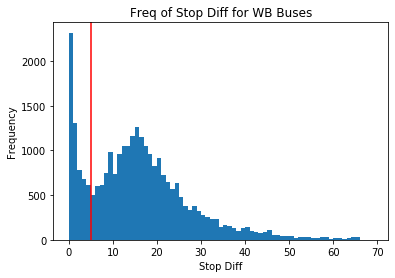

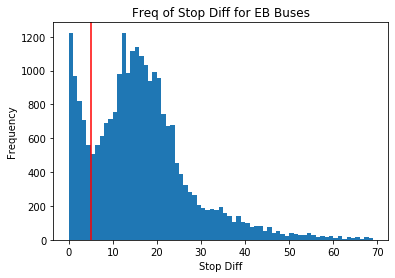

In [20]:
plt.hist(west_bus['STOP_DIFF'], bins=list(range(0, 70, 1)))
plt.ylabel('Frequency')
plt.xlabel('Stop Diff')
plt.title('Freq of Stop Diff for WB Buses')
plt.axvline(x=5, color = 'red')
plt.show()

plt.hist(east_bus['STOP_DIFF'], bins=list(range(0, 70, 1)))
plt.ylabel('Frequency')
plt.xlabel('Stop Diff')
plt.title('Freq of Stop Diff for EB Buses')
plt.axvline(x=5, color = 'red')
plt.show()

In [41]:
east_bunch = east_bus[east_bus['STOP_DIFF'] <= 5]

east_locs = set(east_bunch['STOP_NAME'])
east_cluster = {'lat': [], 'lon': [], 'name': [], 'value': []}
for loc in east_locs:
    temp = east_bunch[east_bunch['STOP_NAME'] == loc]
    east_cluster['name'].append(temp.iloc[0]['STOP_XST'])
    value = round(len(temp)/len(east_bunch)*1000)
    lat = round(temp.iloc[0]['STOP_LAT'], 5)
    lon = round(temp.iloc[0]['STOP_LON'], 5)
    
    east_cluster['value'].append(value)
    east_cluster['lon'].append(lon)
    east_cluster['lat'].append(lat)

east_df = pd.DataFrame(east_cluster)
m = folium.Map(location=[41.8, -87.66], zoom_start=13)
for i in range(0,len(east_df)):
   folium.Circle(
      location=[east_df.iloc[i]['lat'], east_df.iloc[i]['lon']],
      popup=east_df.iloc[i]['name'],
      radius=int(east_df.iloc[i]['value']*10),
      color='crimson',
      fill=False,
      fill_color='crimson'
   ).add_to(m)

m.save('links/55_EB.html')
m

In [42]:
west_bunch = west_bus[west_bus['STOP_DIFF'] <= 5]

west_locs = set(west_bunch['STOP_NAME'])
west_cluster = {'lat': [], 'lon': [], 'name': [], 'value': []}
for loc in west_locs:
    temp = west_bunch[west_bunch['STOP_NAME'] == loc]
    west_cluster['name'].append(temp.iloc[0]['STOP_XST'])
    value = round(len(temp)/len(west_bunch)*1000)
    lat = round(temp.iloc[0]['STOP_LAT'], 5)
    lon = round(temp.iloc[0]['STOP_LON'], 5)
    
    west_cluster['value'].append(value)
    west_cluster['lon'].append(lon)
    west_cluster['lat'].append(lat)

west_df = pd.DataFrame(west_cluster)
m = folium.Map(location=[41.8, -87.66], zoom_start=13)
for i in range(0,len(west_df)):
   folium.Circle(
      location=[west_df.iloc[i]['lat'], west_df.iloc[i]['lon']],
      popup=west_df.iloc[i]['name'],
      radius=int(east_df.iloc[i]['value']*10),
      color='blue',
      fill=False,
      fill_color='blue'
   ).add_to(m)

m.save('links/55_WB.html')
m